## 5. CRISP-DM: Modeling

## Prepared Data

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,ROC AUC,F1 Score,Precision,Recall
Majority Classifier,0.499706,0.500000,0.000000,0.000000,0.000000
Decision Tree (depth=2),0.820284,0.842080,0.825480,0.802732,0.849555
Logistic Regression,0.814061,0.889043,0.821218,0.791212,0.853589
Decision Tree (depth=5),0.855773,0.911242,0.855066,0.859789,0.850395
"Random Forest (estimators=50, depth=5)",0.866454,0.944139,0.871770,0.838850,0.907379
Decision Tree (depth=10),0.917921,0.959631,0.919485,0.902803,0.936796
Decision Tree (depth=None),0.958708,0.966468,0.958715,0.959118,0.958312
Decision Tree (depth=20),0.953494,0.972906,0.953735,0.949367,0.958144
"Random Forest (estimators=200, depth=20)",0.962240,0.993752,0.962593,0.954245,0.971088


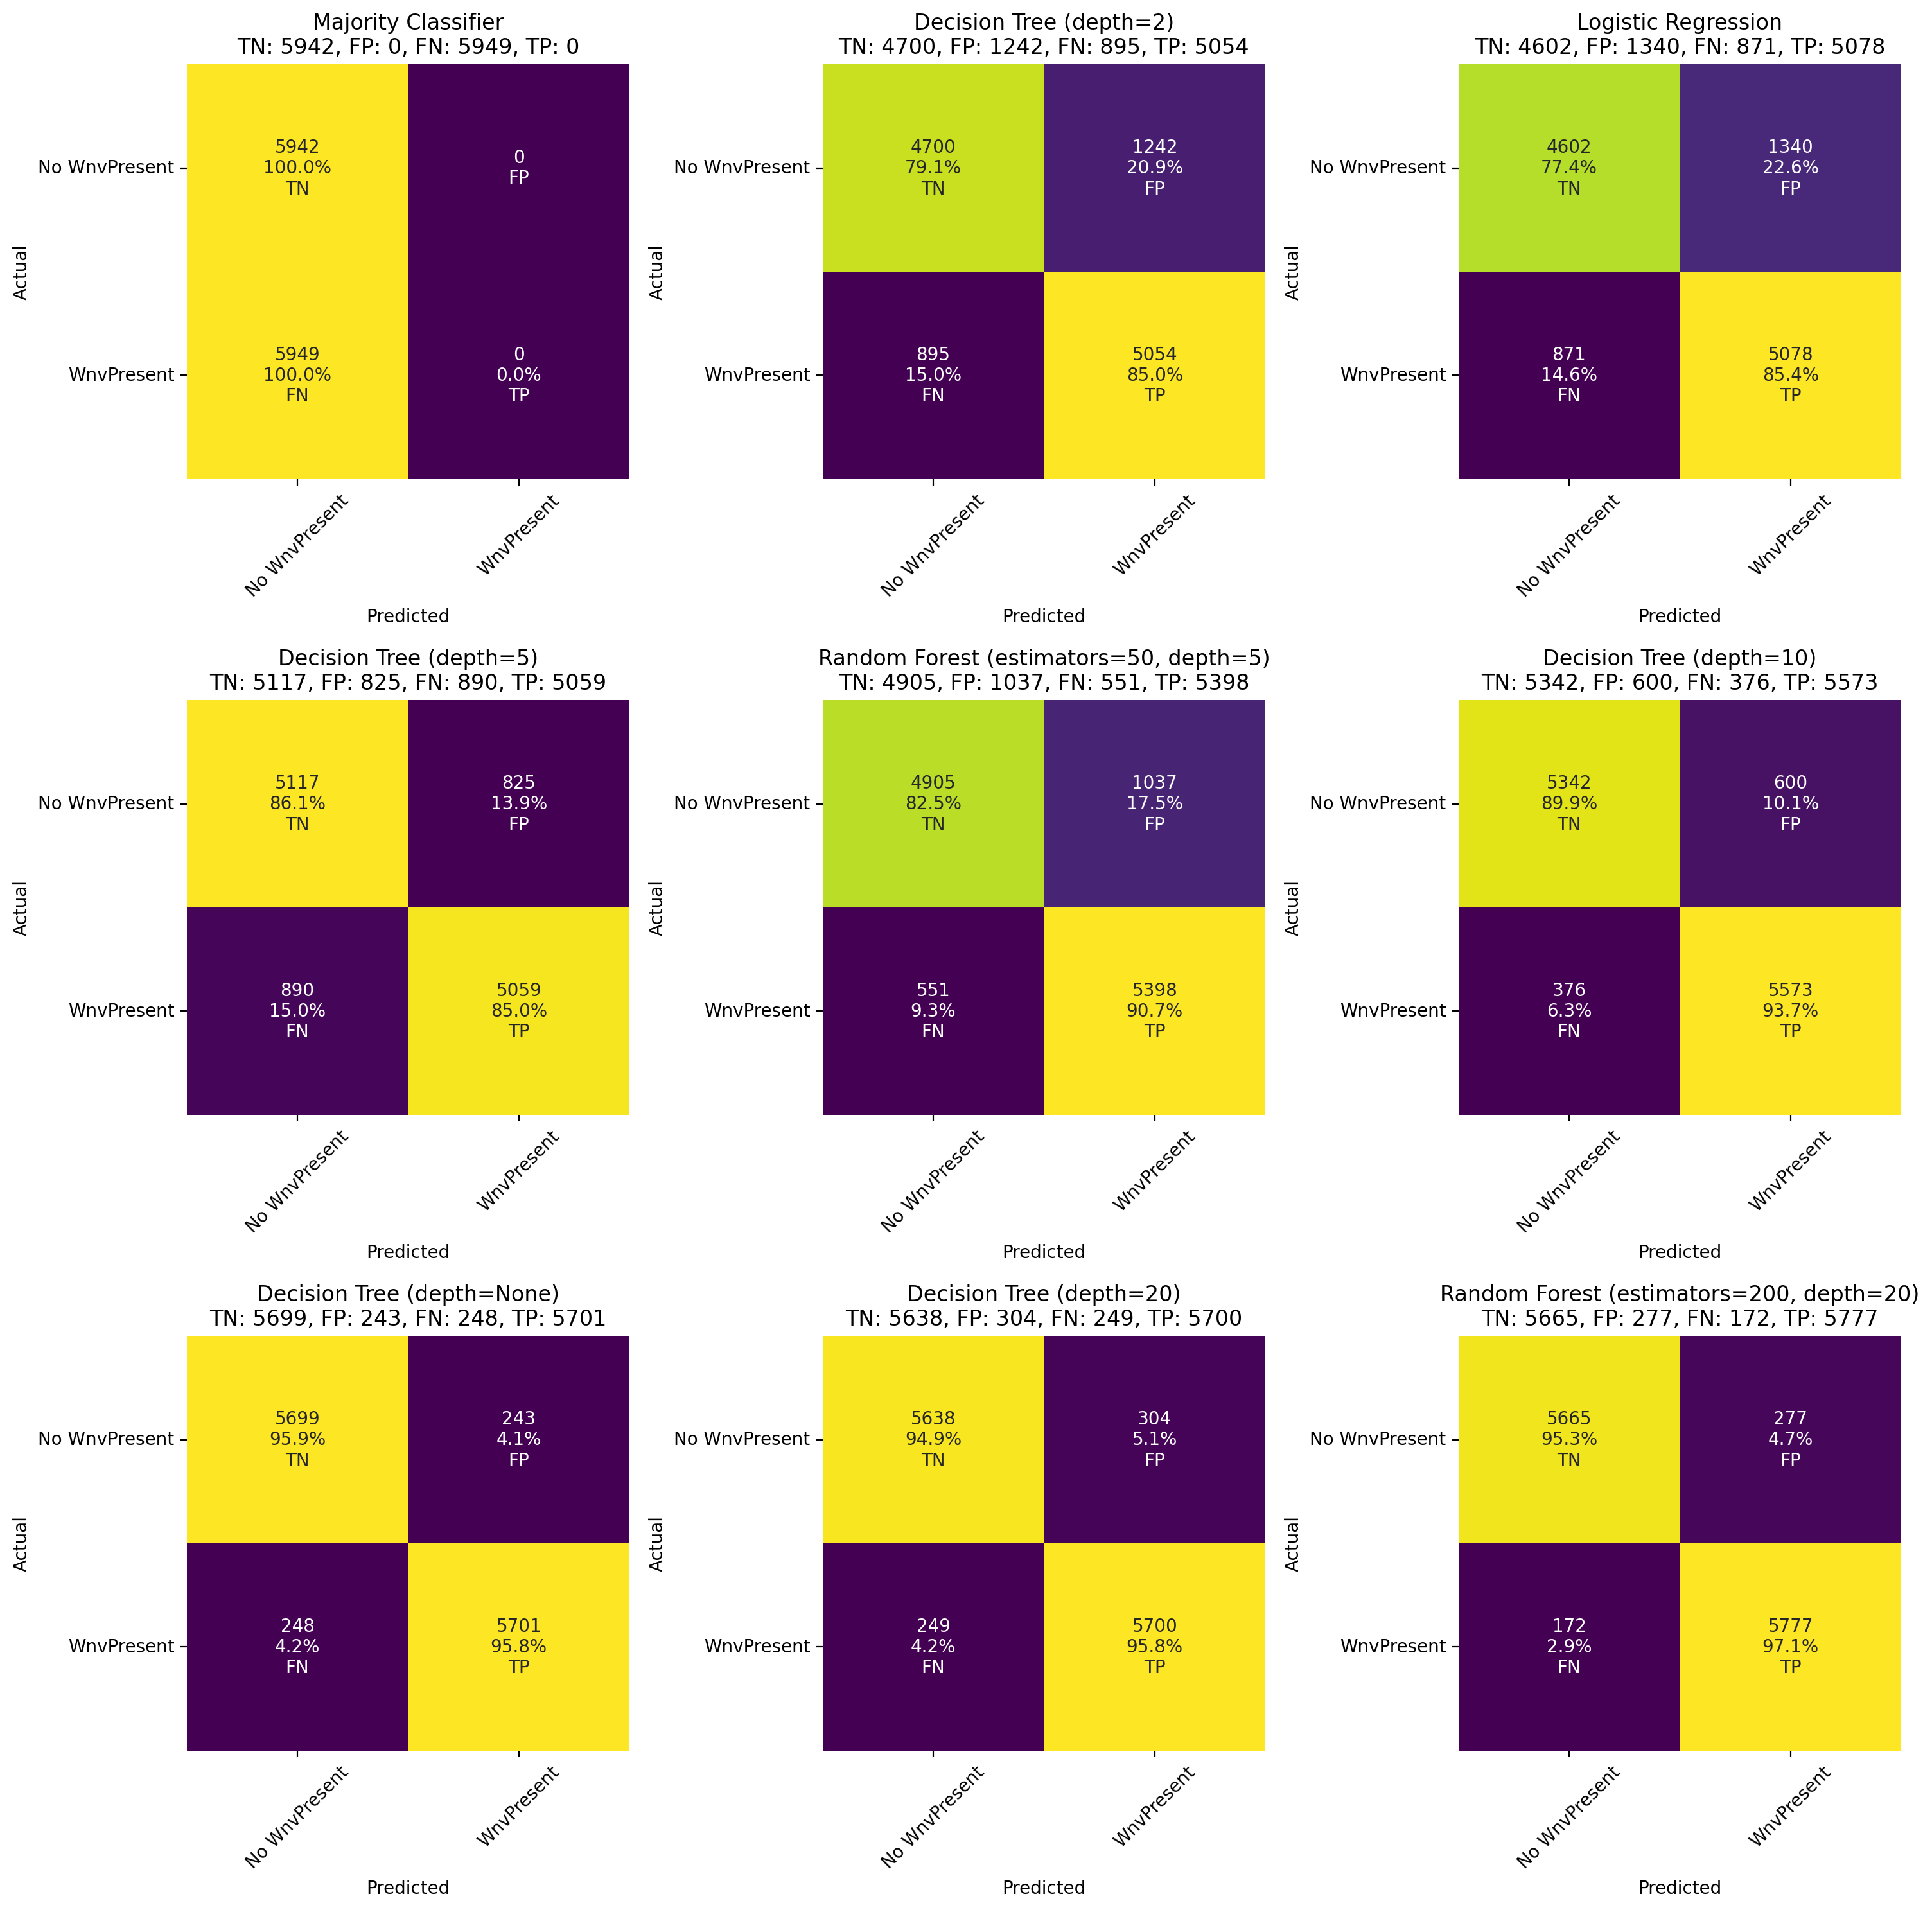

Best parameters for Decision Tree (depth=2): {'max_depth': 20}
Best parameters for Random Forest (estimators=200, depth=20): {'max_depth': None, 'n_estimators': 200}


,Accuracy,ROC AUC,F1 Score,Precision,Recall
Decision Tree (depth=2),0.953662,0.973093,0.953926,0.949085,0.958817
"Random Forest (estimators=200, depth=20)",0.966193,0.995005,0.965926,0.974184,0.957808


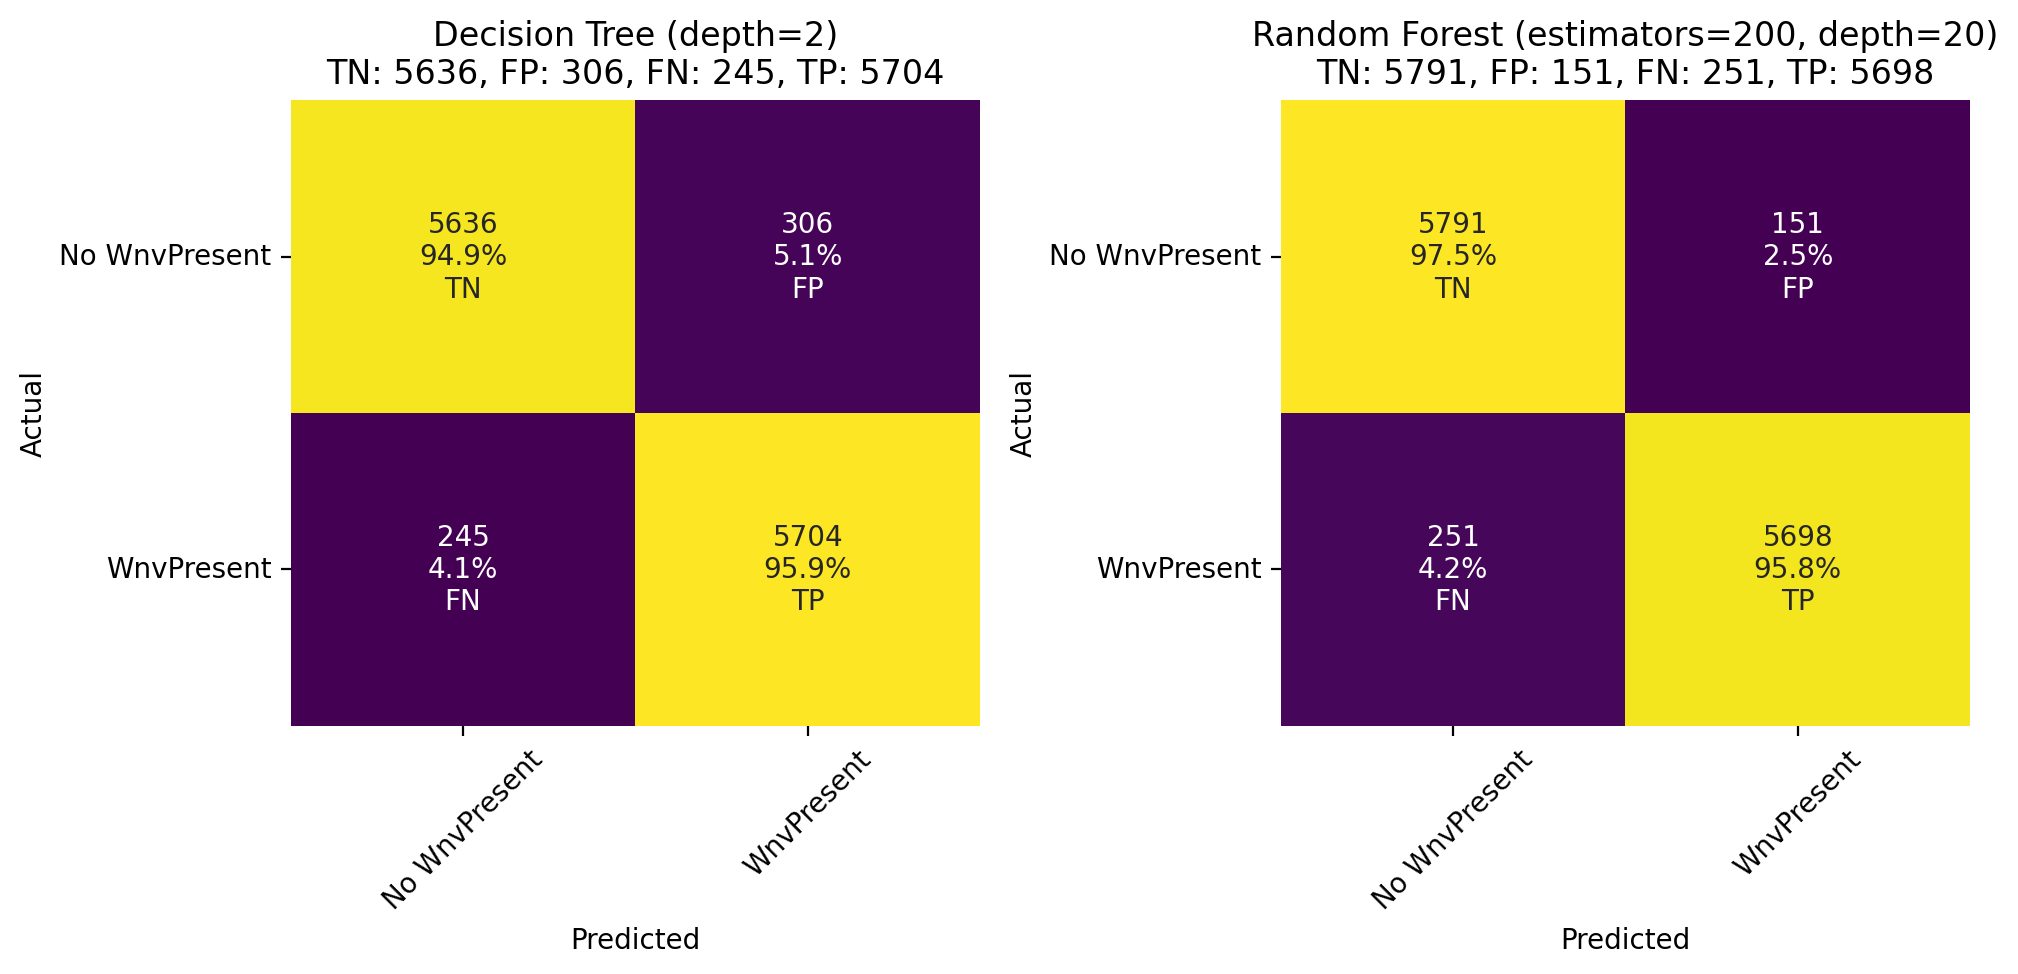

Cross-Validation Scores for RandomForestClassifier(n_estimators=200): [0.99333548 0.9935797  0.9945197  0.99352514 0.99307154]
Mean CV Score: 0.99
Submission file created successfully.


In [116]:
#!/usr/bin/env python
# coding: utf-8

# ## 5. CRISP-DM: Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB  # Import for Naive Bayes
from sklearn.dummy import DummyClassifier  # Import for Majority Classifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import os
from IPython.display import display, Markdown
import seaborn as sns

# Settings for plotting
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'  # High resolution figures")

def prepare_data_for_modeling(train, test):
    # Data preparation
    X = train.drop(["WnvPresent"], axis=1)
    y = train['WnvPresent']
    X_encoded = pd.get_dummies(X, drop_first=True)
    # Apply the same transformation to test data
    test_encoded = pd.get_dummies(test.drop(['Date', 'Id'], axis=1), drop_first=True)
    # Ensure test data has the same columns in the same order
    test_encoded = test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    test_scaled = scaler.transform(test_encoded)  # Use the same scaler to transform test data

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_scaled, y)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, test_scaled

def prepare_models():
    models = {
        'Majority Classifier': DummyClassifier(strategy="most_frequent"),  # Add Majority Classifier
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree (depth=2)': DecisionTreeClassifier(max_depth=2),
        'Decision Tree (depth=5)': DecisionTreeClassifier(max_depth=5),
        'Decision Tree (depth=10)': DecisionTreeClassifier(max_depth=10),
        'Decision Tree (depth=20)': DecisionTreeClassifier(max_depth=20),
        'Decision Tree (depth=None)': DecisionTreeClassifier(max_depth=None),
        'Random Forest (estimators=200, depth=20)': RandomForestClassifier(n_estimators=200, max_depth=20),
        'Random Forest (estimators=50, depth=5)': RandomForestClassifier(n_estimators=50, max_depth=5),
        # 'Random Forest (estimators=100, depth=10)': RandomForestClassifier(n_estimators=100, max_depth=10),
    }
    return models

def train_models(models, X_train, y_train):
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

def plot_confusion_matrix(ax, y_true, y_pred, class_names, classifier_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            if i == j:
                annot[i, j] = f'{c}\n{p:.1f}%\n{"TN" if i == 0 else "TP"}'
            elif c == 0:
                annot[i, j] = f'0\n{"FP" if i == 0 else "FN"}'
            else:
                annot[i, j] = f'{c}\n{p:.1f}%\n{"FP" if i == 0 else "FN"}'

    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=annot, fmt='', cmap='viridis', cbar=False, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'{classifier_name}\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names, rotation=0)

def evaluate_models(trained_models, X_test, y_test, plot_cm=True):
    results = {}
    class_names = ['No WnvPresent', 'WnvPresent']
    for name, model in trained_models.items():
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A',
            'F1 Score': f1_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred)
        }
    results_df = pd.DataFrame(results).T
    
    # Check if 'ROC AUC' exists before sorting
    if 'ROC AUC' in results_df.columns:
        results_df = results_df.sort_values(by='ROC AUC', ascending=True)  # Sort by ROC AUC in ascending order
    
    # Display the results table
    display(results_df)
    
    if plot_cm:
        num_models = len(results_df)
        num_cols = 3
        num_rows = (num_models + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
        axes = axes.flatten()
        
        for idx, name in enumerate(results_df.index):
            model = trained_models[name]
            y_pred = model.predict(X_test)
            plot_confusion_matrix(axes[idx], y_test, y_pred, class_names, name)
        
        # Remove empty subplots
        for i in range(len(results_df), len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
            
    return results_df

def hyperparameter_tuning(models, X_train, y_train):
    param_grid = {
        'Decision Tree (depth=2)': {'max_depth': [2, 5, 10, 20, None]},
        'Random Forest (estimators=200, depth=20)': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
    }
    
    best_models = {}
    for name, params in param_grid.items():
        if name in models:
            grid_search = GridSearchCV(models[name], param_grid=params, cv=5, scoring='roc_auc')
            grid_search.fit(X_train, y_train)
            best_models[name] = grid_search.best_estimator_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    return best_models

def cross_validate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f'Cross-Validation Scores for {model}: {scores}')
    print(f'Mean CV Score: {np.mean(scores):.2f}')

# Main workflow
display(Markdown("## Prepared Data"))
# Load datasets
train_cleaned = pd.read_csv('../data/cleaned_train.csv')
test_cleaned = pd.read_csv('../data/cleaned_test.csv')
X_train, X_test, y_train, y_test, test_scaled = prepare_data_for_modeling(train_cleaned, test_cleaned)

models = prepare_models()
trained_models = train_models(models, X_train, y_train)
results_df = evaluate_models(trained_models, X_test, y_test)

# Perform hyperparameter tuning
best_models = hyperparameter_tuning(models, X_train, y_train)
best_trained_models = train_models(best_models, X_train, y_train)
best_results_df = evaluate_models(best_trained_models, X_test, y_test)

# Cross-validate the best model


best_model = best_trained_models['Random Forest (estimators=200, depth=20)']
cross_validate_model(best_model, X_train, y_train)

# Create submission CSV using the best model
test_predictions = best_model.predict_proba(test_scaled)[:, 1]
test_predictions = np.round(test_predictions, 2)

submission = pd.DataFrame({
    'Id': test_cleaned['Id'],
    'WnvPresent': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

## Confusion Matrix Terminology

- **True Negatives (TN):** The number of instances correctly predicted as not having the condition.
- **True Positives (TP):** The number of instances correctly predicted as having the condition

- **False Positives (FP):** The number of instances incorrectly predicted as having the condition when they do not.
- **False Negatives (FN):** The number of instances incorrectly predicted as not having the condition when they do.
